In [12]:
import os
import gc
import cv2
import glob
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy.io import loadmat
from scipy.stats import spearmanr
from diffusers import MarigoldDepthPipeline
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, ZoeDepthForDepthEstimation

In [2]:
IBIMS_PATH = "/kaggle/input/ibims-1/iBims-1"
NYU_PATH = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test"
KITTI_PATH = "/kaggle/input/kitti-depth-estimation-selection/depth_selection/val_selection_cropped"

DEVICE = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(DEVICE)

cuda


In [3]:
# https://www.asg.ed.tum.de/lmf/ibims1/

class IBimsLoader:
    def __init__(self, root_dir=IBIMS_PATH):
        self.rgb_files = sorted(glob.glob(os.path.join(root_dir, "rgb", "*.png")))
        self.depth_files = sorted(glob.glob(os.path.join(root_dir, "ibims1_core_mat", "*.mat")))
        
        if len(self.rgb_files) != len(self.depth_files):
            print("Hmm something is wrong with the dataset...")

    def __len__(self):
        return len(self.rgb_files)

    def get_item(self, idx):
        img_path = self.rgb_files[idx]
        img = cv2.imread(img_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        depth_path = self.depth_files[idx]
        mat_data = loadmat(depth_path)

        gt_depth = mat_data['data']['depth'][0][0]

        mask = gt_depth > 0.001
        
        return img, gt_depth, mask,img_path

class NyuLoader:
    def __init__(self, root_dir=NYU_PATH, samples_size=100, seed=42):
        self.samples = []
        
        self.rgb_files = sorted(glob.glob(os.path.join(root_dir, "*_colors.png"), recursive=True))
        print(f"Found {len(self.rgb_files)} RGB candidates. Matching with Depth...")

        for rgb_path in self.rgb_files:
            depth_path = rgb_path.replace("_colors.png", "_depth.png")
            if os.path.exists(depth_path):
                self.samples.append((rgb_path, depth_path))
        print(f"Paired {len(self.samples)} Nyu samples.")

        if samples_size is not None and len(self.samples) > samples_size:
            random.seed(seed)
            self.samples = random.sample(self.samples, samples_size)
    
    def __len__(self):
        return len(self.samples)

    def get_item(self, idx):
        img_path, depth_path = self.samples[idx]
        
        img = cv2.imread(img_path)
        depth_png = cv2.imread(depth_path, -1)
        if depth_png is None:
            raise ValueError(f"Failed to load depth: {depth_path}")

        gt_depth = depth_png.astype(np.float32) / 1000.0
        mask = gt_depth > 0.001

        return img, gt_depth, mask, img_path

class KittiLoader:
    def __init__(self, root_dir=KITTI_PATH, samples_size=100, seed=42):
        self.samples = []
        self.samples_size = samples_size

        image_dir = os.path.join(root_dir, "image")
        depth_dir = os.path.join(root_dir, "groundtruth_depth")

        self.rgb_files = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        print(f"Found {len(self.rgb_files)} KITTI images. Matching with Depth...")
        
        for rgb_path in self.rgb_files:
            rgb_filename = os.path.basename(rgb_path)
            
            depth_filename = rgb_filename.replace("_sync_image_", "_sync_groundtruth_depth_")
            depth_path = os.path.join(depth_dir, depth_filename)
            
            if os.path.exists(depth_path):
                self.samples.append((rgb_path, depth_path))
            else:
                if len(self.samples) == 0:
                    print(f"Failed to find: {depth_path}")
        print(f"Paired {len(self.samples)} KITTI samples.")
        
        if samples_size and len(self.samples) > samples_size:
            random.seed(seed)
            self.samples = random.sample(self.samples, samples_size)

    def __len__(self):
        return len(self.samples)

    def get_item(self, idx):
        img_path, depth_path = self.samples[idx]
        img = cv2.imread(img_path)
        
        depth_png = cv2.imread(depth_path, -1)
        gt_depth = depth_png.astype(np.float32) / 256.0
        
        mask = (gt_depth > 0.001) & (gt_depth < 80.0)

        return img, gt_depth, mask, img_path

In [4]:
#  https://huggingface.co/blog/Isayoften/monocular-depth-estimation-guide

def get_absrel(gt, pred):
    return np.mean(np.abs(gt-pred)/gt)

def get_delta(gt, pred, exponent=1):
    inlier = np.maximum((gt/pred), (pred/gt))
    return np.mean(inlier < 1.25**exponent)

def get_silog(gt, pred):
    """
    Computes Scale Invariant Logarithmic Error.
    Lower is better.
    """
    pred = np.maximum(pred, 1e-5)
    gt = np.maximum(gt, 1e-5)

    err = np.log(pred) - np.log(gt)

    silog = np.sqrt(np.mean(err ** 2) - (np.mean(err)) ** 2)
    
    return silog * 100

def align_depth_least_square(gt_arr, pred_arr, valid_mask_arr):
    ori_shape = pred_arr.shape

    gt = gt_arr.squeeze()  # [H, W]
    pred = pred_arr.squeeze()
    valid_mask = valid_mask_arr.squeeze()
    gt_masked = gt[valid_mask].reshape((-1, 1))
    pred_masked = pred[valid_mask].reshape((-1, 1))

    # numpy solver
    _ones = np.ones_like(pred_masked)
    A = np.concatenate([pred_masked, _ones], axis=-1)
    X = np.linalg.lstsq(A, gt_masked, rcond=None)[0]
    scale, shift = X

    aligned_pred = pred_arr * scale + shift

    # restore dimensions
    aligned_pred = aligned_pred.reshape(ori_shape)

    return aligned_pred, scale, shift

In [5]:
class ModelWrapper:
    def __init__(self, choice):
        self.choice = choice
        
        if "marigold" in choice.lower():
            self.model = MarigoldDepthPipeline.from_pretrained(choice, variant="fp16").to(DEVICE)
            self.model.set_progress_bar_config(disable=True)
            print("found marigold model")
        elif "zoedepth" in choice.lower():
            self.processor = AutoImageProcessor.from_pretrained(choice)
            self.model = ZoeDepthForDepthEstimation.from_pretrained(choice).to(DEVICE)
            print("found zoedepth model")
        else:
            self.processor = AutoImageProcessor.from_pretrained(choice)
            self.model = AutoModelForDepthEstimation.from_pretrained(choice).to(DEVICE)

    def infer(self, image_path, marigold_steps=4):
        if "marigold" in self.choice.lower():
            image = Image.open(image_path).convert("RGB")
            w0, h0 = image.size
            
            with torch.no_grad():
                pipe_out = self.model(
                    image, 
                    num_inference_steps=marigold_steps, 
                    output_type="pt"
                )
            prediction = pipe_out.prediction

            # Check if resize is needed
            if prediction.shape[-2:] != (h0, w0):
                prediction = torch.nn.functional.interpolate(
                    prediction,
                    size=(h0, w0),
                    mode="bicubic",
                    align_corners=False
                )

            return prediction.squeeze().cpu().numpy()

        # Transformer-based models inference
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        inputs = self.processor(images=image, return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            predicted_depth = outputs.predicted_depth
        
        # Resize to original image size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        )
        
        return prediction.squeeze().cpu().numpy()

In [75]:
# Check if dataset gt is in mm
# dataset = ...
for i in range(len(dataset)):
    _, gt, _, _ = dataset.get_item(i)
    if np.median(gt) > 100:
        print("maybe that measurement is in millimeters... needs to change!")

In [9]:
ibims_loader = IBimsLoader()
nyu_loader = NyuLoader()
kitti_loader = KittiLoader()

class ModelConfig:
    def __init__(self, model_choice, display_name, relative=True, ibims=ibims_loader, nyu=nyu_loader, kitti=kitti_loader):
        self.model_choice = model_choice 
        self.model = None
        self.display_name = display_name
        self.relative = relative
        self.ibims = ibims
        self.nyu = nyu
        self.kitti = kitti
        self.absrel = {}
        self.d1 = {}
        self.silog = {}

    def __load_model(self):
        self.model = ModelWrapper(self.model_choice)

    def __unload_model(self):
        del self.model
        self.model = None
        gc.collect()
        torch.cuda.empty_cache()
        
    def set_results(self, dataset, absrel, d1, silog):
        self.absrel[dataset] = absrel;
        self.d1[dataset] = d1
        self.silog[dataset] = silog

    def get_absrel_result(self, dataset):
        return self.absrel[dataset]

    def get_d1_result(self, dataset):
        return self.d1[dataset]

    def get_silog_result(self, dataset):
        return self.silog[dataset]

    def __check_if_disparity(self, dataset, num_samples=5):
        """
        Checks if model output is Disparity (needs 1/x) or Depth.
        Returns True if the output is Disparity (Negative Correlation with GT).
        """
        correlations = []
        indices = np.linspace(0, len(dataset)-1, num_samples, dtype=int)
        
        for i in indices:
            _, gt, mask, image_path = dataset.get_item(i)
            prediction = self.model.infer(image_path)
            
            if mask.sum() == 0: continue
            
            val_pred = prediction[mask]
            val_gt = gt[mask]
            
            if len(val_gt) > 5000:
                val_pred = val_pred[::100]
                val_gt = val_gt[::100]

            # Spearman Correlation (rank-based, robust to scale)
            corr, _ = spearmanr(val_pred, val_gt)
            correlations.append(corr)
        
        avg_corr = np.mean(correlations)
        
        # If correlation is negative, values decrease as distance increases -> Disparity
        return avg_corr < -0.1
    
    def __basic_benchmark(self, dataset, debug=True):
        absrel_list = []
        delta_list = []
        silog_list = []
        
        ds = "ibims"
        if isinstance(dataset, NyuLoader):
            ds = "nyu"
        elif isinstance(dataset, KittiLoader):
            ds = "kitti"

        needs_inversion = self.__check_if_disparity(dataset)
        if debug and needs_inversion:
            print(f"\tModel outputs Disparity (negative correlation). Inverting predictions (1/x)...")
        
        for i in tqdm(range(len(dataset))):
            _, gt, mask, image_path = dataset.get_item(i)
            prediction = self.model.infer(image_path)
            
            if ds == "nyu":
                # Standard Eigen Crop (Top, Bottom, Left, Right)
                # [45:471, 41:601] is the valid region for 640x480 images
                height, width = gt.shape
                crop_mask = np.zeros((height, width), dtype=bool)
                
                y1, y2 = 45, min(471, height)
                x1, x2 = 41, min(601, width)
                crop_mask[y1:y2, x1:x2] = True
                
                mask = mask & crop_mask
            elif ds == "kitti":
                # Apply KITTI Garg Crop
                height, width = gt.shape
                crop_mask = np.zeros((height, width), dtype=bool)
                y1, y2 = int(0.40810811 * height), int(0.99189189 * height)
                x1, x2 = int(0.03594771 * width), int(0.96405229 * width)
                
                crop_mask[y1:y2, x1:x2] = True
                mask = mask & crop_mask 

            # Skip invalid masks
            if mask.sum() == 0: continue
            
            if self.relative:
                if needs_inversion:
                    gt_disparsity = np.zeros_like(gt)
                    gt_disparsity[mask] = 1.0 / gt[mask]
                    aligned_disp, _, _ = align_depth_least_square(gt_disparsity, prediction, mask)
                    aligned_disp = np.maximum(aligned_disp, 1e-6)
                    pred_final = 1.0 / aligned_disp
                else:
                    aligned_depth, _, _ = align_depth_least_square(gt, prediction, mask)
                    pred_final = np.maximum(aligned_depth, 1e-6)
            else:
                pred_final = prediction

            gt_valid = gt[mask]
            pred_valid = pred_final[mask]
            absrel = get_absrel(gt_valid, pred_valid)
            delta = get_delta(gt_valid, pred_valid, 1)
            silog = get_silog(gt_valid, pred_valid)
            
            absrel_list.append(absrel)
            delta_list.append(delta)
            silog_list.append(silog)
            
        am = np.mean(absrel_list)
        dm = np.mean(delta_list)
        sm = np.mean(silog_list)
        self.set_results(ds, am, dm, sm)

        if debug:
            print(f"\tAverage AbsRel = {am:.4f}")
            print(f"\tAverage Delta1 = {dm:.4f}")
            print(f"\tAverage SILog  = {sm:.4f}")

    def benchmark(self, debug=True):
        self.__load_model()

        try:
            print(f"{'='*20}[ {self.display_name} ]{'='*20}")
            
            if self.ibims is not None:
                print("IBims-1 dataset:")
                self.__basic_benchmark(self.ibims, debug=debug)
                
            if self.nyu is not None:
                print("NYU Depth V2 dataset:")
                self.__basic_benchmark(self.nyu, debug=debug)
                
            if self.kitti is not None:
                print("KITTI dataset:")
                self.__basic_benchmark(self.kitti, debug=debug)
                
            print(f"{'='*20}[ {self.display_name} ]{'='*20}\n")
        finally:
            self.__unload_model()

Found 654 RGB candidates. Matching with Depth...
Paired 654 Nyu samples.
Found 1000 KITTI images. Matching with Depth...
Paired 1000 KITTI samples.


In [17]:
kitti_conf = ModelConfig("depth-anything/Depth-Anything-V2-Metric-Outdoor-Large-hf", "test", ibims=None, nyu=None, relative=False)
kitti_conf.benchmark(debug=True)

====================[ test ]====================
KITTI dataset:


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]

	Average AbsRel = 0.0913
	Average Delta1 = 0.9179
	Average SILog  = 11.6398
====================[ test ]====================



In [10]:
configs = [
    ModelConfig("depth-anything/Depth-Anything-V2-Large-hf", "DAV2-Large"),
    ModelConfig("depth-anything/Depth-Anything-V2-Metric-Indoor-Large-hf", "DAV2-Indoor-Metric", relative=False),
    ModelConfig("depth-anything/Depth-Anything-V2-Metric-Outdoor-Large-hf", "DAV2-Outdoor-Metric", relative=False),
    ModelConfig("Intel/zoedepth-nyu-kitti", "ZoeDepth", relative=False),
    ModelConfig("Intel/dpt-large", "MiDaS-3.0"),
    ModelConfig("Intel/dpt-beit-large-512", "MiDaS-3.1"),
    ModelConfig("prs-eth/marigold-depth-v1-1", "Marigold-1.1")
]

for config in configs:
    config.benchmark(debug=True)

====================[ DAV2-Large ]====================
IBims-1 dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


	Average AbsRel = 0.1335
	Average Delta1 = 0.9783
	Average SILog  = 7.0373
NYU Depth V2 dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


	Average AbsRel = 0.0541
	Average Delta1 = 0.9644
	Average SILog  = 8.5579
KITTI dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


	Average AbsRel = 0.1138
	Average Delta1 = 0.9625
	Average SILog  = 10.0612
====================[ DAV2-Large ]====================



preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

====================[ DAV2-Indoor-Metric ]====================
IBims-1 dataset:


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


	Average AbsRel = 0.1265
	Average Delta1 = 0.8861
	Average SILog  = 7.5893
NYU Depth V2 dataset:


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


	Average AbsRel = 0.2196
	Average Delta1 = 0.6744
	Average SILog  = 9.5989
KITTI dataset:


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


	Average AbsRel = 0.5600
	Average Delta1 = 0.0011
	Average SILog  = 12.5793
====================[ DAV2-Indoor-Metric ]====================



preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

====================[ DAV2-Outdoor-Metric ]====================
IBims-1 dataset:


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


	Average AbsRel = 3.1852
	Average Delta1 = 0.0003
	Average SILog  = 14.5571
NYU Depth V2 dataset:


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


	Average AbsRel = 4.2838
	Average Delta1 = 0.0000
	Average SILog  = 19.6063
KITTI dataset:


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


	Average AbsRel = 0.0913
	Average Delta1 = 0.9179
	Average SILog  = 11.6398
====================[ DAV2-Outdoor-Metric ]====================



preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

found zoedepth model
====================[ ZoeDepth ]====================
IBims-1 dataset:


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


	Average AbsRel = 0.2009
	Average Delta1 = 0.6119
	Average SILog  = 16.8612
NYU Depth V2 dataset:


100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


	Average AbsRel = 0.1464
	Average Delta1 = 0.8267
	Average SILog  = 17.2433
KITTI dataset:


100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


	Average AbsRel = 0.1049
	Average Delta1 = 0.9065
	Average SILog  = 14.4071
====================[ ZoeDepth ]====================



preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


====================[ MiDaS-3.0 ]====================
IBims-1 dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


	Average AbsRel = 53.1020
	Average Delta1 = 0.9413
	Average SILog  = 12.1237
NYU Depth V2 dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


	Average AbsRel = 0.1028
	Average Delta1 = 0.9007
	Average SILog  = 13.6986
KITTI dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


	Average AbsRel = 0.2390
	Average Delta1 = 0.9124
	Average SILog  = 14.2184
====================[ MiDaS-3.0 ]====================



preprocessor_config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

====================[ MiDaS-3.1 ]====================
IBims-1 dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


	Average AbsRel = 1.0422
	Average Delta1 = 0.9661
	Average SILog  = 8.9308
NYU Depth V2 dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


	Average AbsRel = 0.0521
	Average Delta1 = 0.9694
	Average SILog  = 8.1113
KITTI dataset:
	Model outputs Disparity (negative correlation). Inverting predictions (1/x)...


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


	Average AbsRel = 0.0651
	Average Delta1 = 0.9575
	Average SILog  = 10.1510
====================[ MiDaS-3.1 ]====================



model_index.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/1.73G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

found marigold model
====================[ Marigold-1.1 ]====================
IBims-1 dataset:


100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


	Average AbsRel = 0.0552
	Average Delta1 = 0.9653
	Average SILog  = 8.2920
NYU Depth V2 dataset:


100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


	Average AbsRel = 0.0714
	Average Delta1 = 0.9408
	Average SILog  = 10.1622
KITTI dataset:


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


	Average AbsRel = 0.1033
	Average Delta1 = 0.8987
	Average SILog  = 14.1911
====================[ Marigold-1.1 ]====================



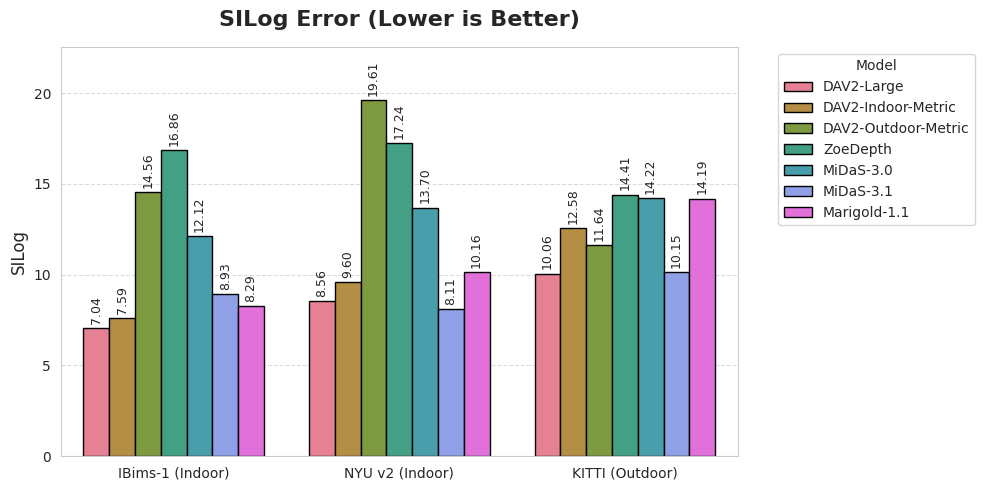

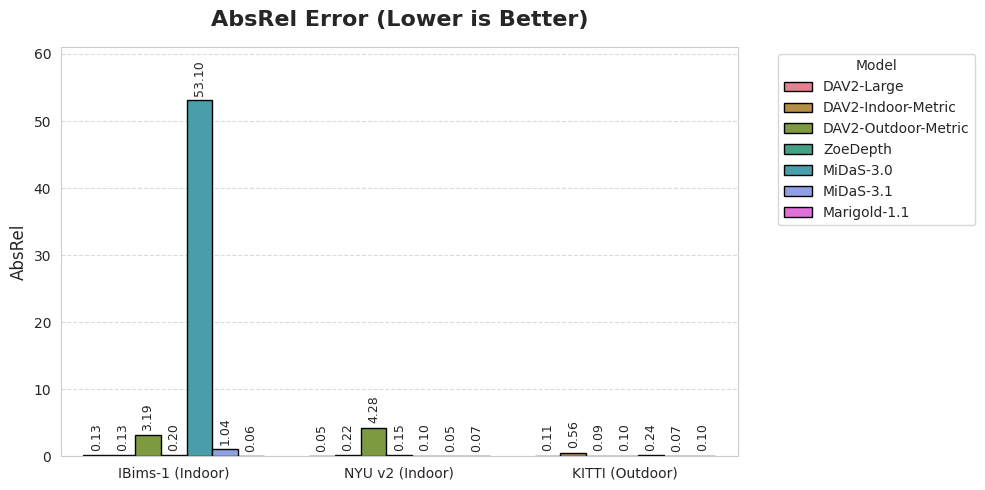

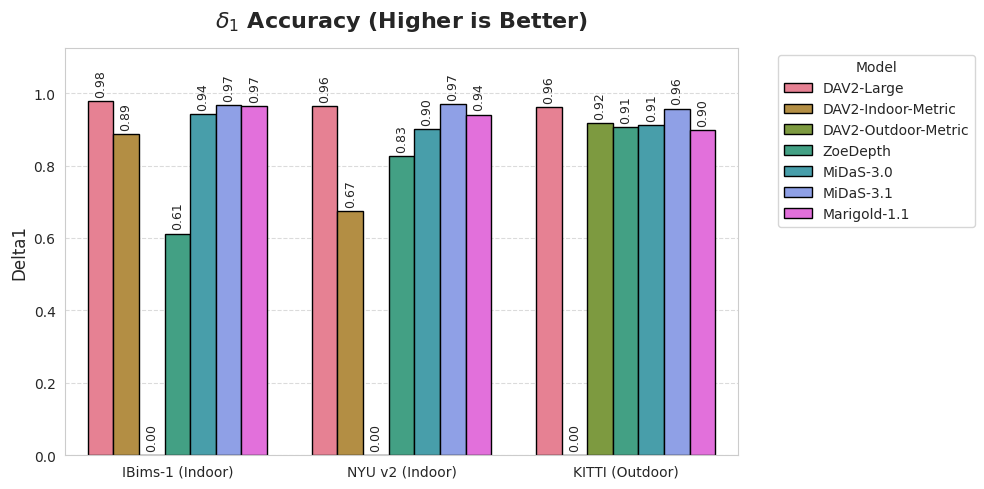

In [18]:
def plot_benchmark_results(configs):
    data = []
    datasets = ["ibims", "nyu", "kitti"] 
    display_names = {"ibims": "IBims-1 (Indoor)", "nyu": "NYU v2 (Indoor)", "kitti": "KITTI (Outdoor)"}
    
    for conf in configs:
        model_name = conf.display_name
        
        for ds in datasets:
            try:
                absrel = conf.get_absrel_result(ds)
                d1 = conf.get_d1_result(ds)
                silog = conf.get_silog_result(ds)

                data.append({
                    "Model": model_name,
                    "Dataset": display_names[ds],
                    "AbsRel": absrel,
                    "Delta1": d1,
                    "SILog": silog
                })
            except KeyError:
                continue

    df = pd.DataFrame(data)

    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", len(configs))
    
    metrics = [
        ("SILog", "SILog Error (Lower is Better)"),
        ("AbsRel", "AbsRel Error (Lower is Better)"),
        ("Delta1", "$\\delta_1$ Accuracy (Higher is Better)")
    ]

    for metric, title in metrics:
        plt.figure(figsize=(10, 5))
        
        ax = sns.barplot(
            data=df, 
            x="Dataset", 
            y=metric, 
            hue="Model", 
            palette=palette,
            edgecolor="black"
        )
        
        max_val = df[metric].max()
        plt.ylim(0, max_val * 1.15)
        
        plt.title(title, fontsize=16, fontweight='bold', pad=15)
        plt.xlabel("", fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9, rotation=90)

        plt.tight_layout()
        plt.savefig(f"/kaggle/working/{metric}.png")
        plt.show()

plot_benchmark_results(configs)

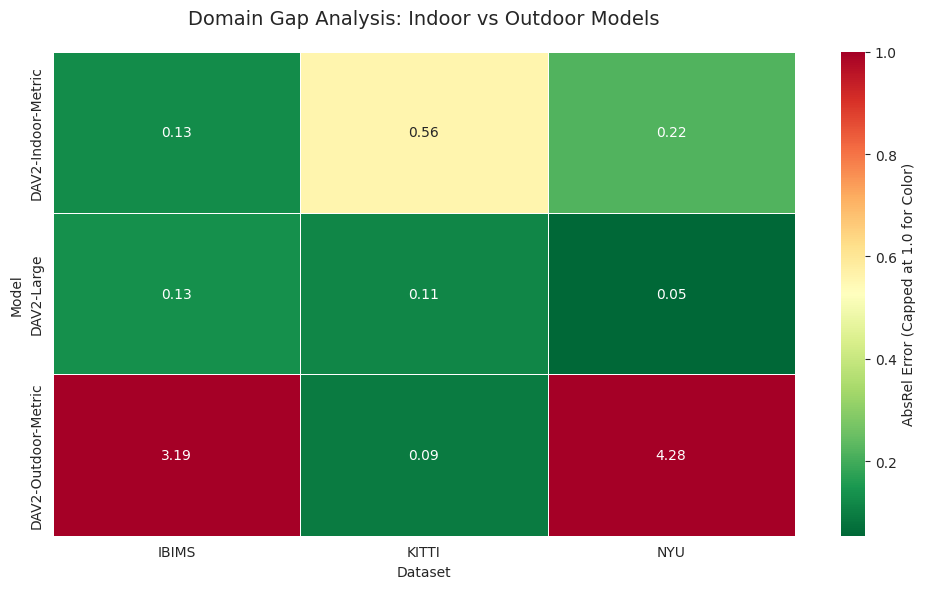

In [17]:
def plot_domain_gap_heatmap(configs):
    target_models = ["DAV2-Indoor-Metric", "DAV2-Outdoor-Metric", "DAV2-Large"]
    data = []
    
    for conf in configs:
        if conf.display_name not in target_models:
            continue
            
        # AbsRel highlights the scale failure best
        for ds_name in ["ibims", "nyu", "kitti"]:
            val = conf.get_absrel_result(ds_name)
            if val is not None:
                val_viz = min(val, 1.0) 
                
                data.append({
                    "Model": conf.display_name,
                    "Dataset": ds_name.upper(),
                    "AbsRel": val_viz,
                    "Real_Value": val
                })

    df = pd.DataFrame(data)
    
    pivot_table = df.pivot(index="Model", columns="Dataset", values="AbsRel")
    annot_table = df.pivot(index="Model", columns="Dataset", values="Real_Value")

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pivot_table, 
        annot=annot_table, # Show the REAL values (e.g. 4.28) in the box
        fmt=".2f", 
        cmap="RdYlGn_r", # Red = High Error, Green = Low Error
        cbar_kws={'label': 'AbsRel Error (Capped at 1.0 for Color)'},
        linewidths=.5
    )
    plt.title("Domain Gap Analysis: Indoor vs Outdoor Models", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig("/kaggle/working/domain_gap.png")
    plt.show()

plot_domain_gap_heatmap(configs)

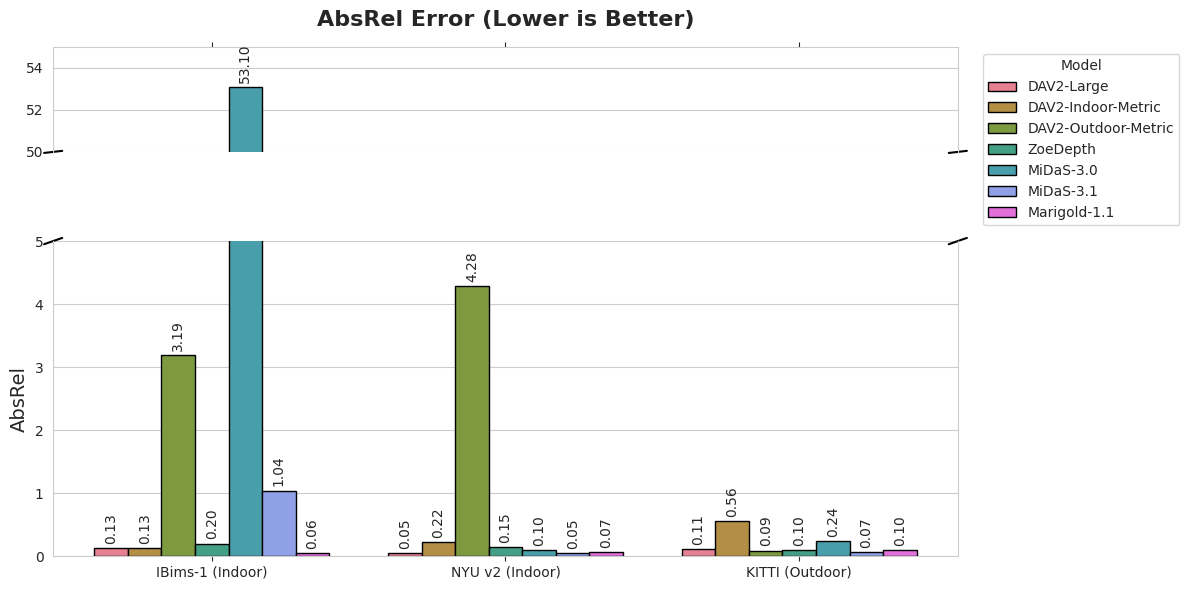

In [24]:
def plot_broken_axis_absrel(configs):
    data = []
    datasets = ["ibims", "nyu", "kitti"] 
    pretty_names = {"ibims": "IBims-1 (Indoor)", "nyu": "NYU v2 (Indoor)", "kitti": "KITTI (Outdoor)"}
    
    for conf in configs:
        model_name = conf.display_name
        for ds in datasets:
            try:
                absrel = conf.get_absrel_result(ds)
                if absrel is None: continue
                data.append({
                    "Model": model_name,
                    "Dataset": pretty_names.get(ds, ds),
                    "AbsRel": absrel
                })
            except KeyError:
                continue

    df = pd.DataFrame(data)

    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", len(configs))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6), 
                                   gridspec_kw={'height_ratios': [1, 3]})
    fig.subplots_adjust(hspace=0.1)

    sns.barplot(data=df, x="Dataset", y="AbsRel", hue="Model", palette=palette, edgecolor="black", ax=ax1)
    sns.barplot(data=df, x="Dataset", y="AbsRel", hue="Model", palette=palette, edgecolor="black", ax=ax2)

    ax2.set_ylim(0, 5.0)
    ax1.set_ylim(50, 55)

    ax2.get_legend().remove()
    ax1.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left')
    
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)
    ax2.xaxis.tick_bottom()

    d = .01  
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

    kwargs.update(transform=ax2.transAxes) 
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

    ax1.set_title("AbsRel Error (Lower is Better)", fontsize=16, fontweight='bold', pad=15)
    ax2.set_ylabel("AbsRel", fontsize=14)
    ax1.set_ylabel("") 
    ax2.set_xlabel("", fontsize=12)

    for container in ax1.containers:
        labels = [f'{v.get_height():.2f}' if v.get_height() > 50 else '' for v in container]
        ax1.bar_label(container, labels=labels, padding=3, fontsize=10, rotation=90)
    
    for container in ax2.containers:
        # Only label bars < 50
        labels = [f'{v.get_height():.2f}' if v.get_height() < 50 else '' for v in container]
        ax2.bar_label(container, labels=labels, padding=3, fontsize=10, rotation=90)

    plt.tight_layout()
    plt.savefig("/kaggle/working/absrel_broken.png")
    plt.show()

plot_broken_axis_absrel(configs)